<a href="https://colab.research.google.com/github/Chantm7777/7-Tech-Stock-Price-Prediction_LSTM.ipynb/blob/main/My_Own_Project_LSTM_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [ ]:
pip install gspread gspread_dataframe

In [ ]:
pip install ta

In [ ]:
pip install arch

In [ ]:
pip install keras-tuner


In [ ]:
from tqdm import tqdm

In [ ]:
import pickle

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import yfinance as yf
import ta
from datetime import datetime
import numpy as np

In [ ]:
from arch import arch_model

In [ ]:
import os

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import shutil
shutil.rmtree('tuner_dir', ignore_errors=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from queue import Queue
from tqdm import tqdm  # For the progress bar
import pandas as pd
from datetime import datetime
import threading
import seaborn as sns

In [ ]:
from collections import Counter

In [ ]:
import keras_tuner as kt


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from tqdm import tqdm  # For progress bars
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##Frame work

initial stage for model building for the 7 tech stock prediction
Prerequisite: separate the stocks by symbols, loop all the symbols for following steps
1. Get the data
2. Do the cleaning
3. Calculation the stock indicators
4. Do the correlation analysis,
5. Do the Random Forest
6. Do the RFE
7. Do the Permutation Importance check
8. Combine all the common and drop the uncommon the few uncommon
9. Do the scaling
10. Set up the LSTM model
11. Test the parameters of the model by using keras tuner and check the validation loss of each epoch
12. Determine the parameters
13. Split the data to 70/30 chronologically
14. Train the model and check the validation loss of each epoch
- using moving window logic, actual week 1,2,3,4 to predict week 5, then include week 2,3,4,5 to predict week 6
15. Track the validation loss
16. Do the back testing
17. Track the model performance
18. Do the prediction if the model is OK
19. Save model, features, scalers for each stock
Weekly/ Bi- weekly Operation
1. Get the data
2. Do the cleaning
3. Calculation the stock indicators
4. Do the scaling
5. Use the most recent data for pre-training
6. Track the validation
7. Do the prediction








In [ ]:

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 1: Data Preparation

In [ ]:
# 1. Data Fetching Function - Already supports multiple stocks
def fetch_data(symbol, start_date, end_date):
    """Fetch historical stock data using yfinance."""
    try:
        data = yf.download(symbol, start=start_date, end=end_date)
        data.index = pd.to_datetime(data.index)
        print(f"Successfully downloaded {len(data)} rows for {symbol}")
        return data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

In [ ]:
# 2. Data Preparation Function
def prepare_data(data, symbol):
    """Prepare and clean the data for analysis."""
    df = data.copy()

    # Handle MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        # Just take the first level (Open, High, Low, Close, etc.)
        df.columns = df.columns.get_level_values(0)

    # Add symbol column
    df['Symbol'] = symbol

    # Verify required columns exist
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    return df# 3. Handle Missing Values - Simple approach
def handle_missing_values(data):
    """Simple approach to handle missing values for stock prediction."""
    # Count NaNs before handling
    nan_count = data.isna().sum().sum()
    total_cells = data.size
    nan_percentage = (nan_count / total_cells) * 100

    print(f"Dataset contains {nan_count} missing values ({nan_percentage:.2f}% of all data)")

    # Drop rows with any NaN values
    cleaned_data = data.dropna()

    # Report rows dropped
    dropped = len(data) - len(cleaned_data)
    drop_percentage = (dropped / len(data)) * 100
    print(f"Dropped {dropped} rows ({drop_percentage:.2f}% of rows) with NaN values")

    return cleaned_data

In [ ]:
# 4. Corrected VWAP calculation function
def calculate_daily_vwap(data):
    """Calculate the Volume-Weighted Average Price on a daily basis."""
    result = []

    # Process each symbol separately
    for symbol in data['Symbol'].unique():
        df = data[data['Symbol'] == symbol].copy()

        # Extract date (without time) from index
        df['DateOnly'] = df.index.date

        # Calculate typical price
        df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3

        # Calculate VWAP for each day
        df['VWAP'] = df.groupby('DateOnly').apply(
            lambda x: (x['TypicalPrice'] * x['Volume']).cumsum() / x['Volume'].cumsum()
        ).reset_index(level=0, drop=True)

        # Drop temporary columns
        df = df.drop(columns=['DateOnly', 'TypicalPrice'])

        result.append(df)

    # Combine results
    return pd.concat(result)['VWAP']# 5. Technical Indicators Function
def add_technical_indicators(data):
    """Add technical indicators to the stock data."""
    # Process each symbol separately to avoid mixing data across stocks
    symbols = data['Symbol'].unique()
    result_dfs = []

    for symbol in symbols:
        symbol_data = data[data['Symbol'] == symbol].copy()

        # Add Relative Strength Index (RSI)
        symbol_data['RSI'] = ta.momentum.RSIIndicator(
            close=symbol_data['Close'], window=14, fillna=True
        ).rsi()

        # Add Moving Average Convergence Divergence (MACD)
        macd = ta.trend.MACD(
            close=symbol_data['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=True
        )
        symbol_data['MACD'] = macd.macd()
        symbol_data['MACD_signal'] = macd.macd_signal()
        symbol_data['MACD_diff'] = macd.macd_diff()

        # Add Bollinger Bands
        bb = ta.volatility.BollingerBands(
            close=symbol_data['Close'], window=20, window_dev=2, fillna=True
        )
        symbol_data['BB_upper'] = bb.bollinger_hband()
        symbol_data['BB_lower'] = bb.bollinger_lband()
        symbol_data['BB_width'] = bb.bollinger_wband()

        # Add Average True Range (ATR)
        symbol_data['ATR'] = ta.volatility.AverageTrueRange(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            window=14, fillna=True
        ).average_true_range()

        # Add Exponential Moving Average (EMA)
        symbol_data['EMA_20'] = ta.trend.EMAIndicator(
            close=symbol_data['Close'], window=20, fillna=True
        ).ema_indicator()
        symbol_data['EMA_50'] = ta.trend.EMAIndicator(
            close=symbol_data['Close'], window=50, fillna=True
        ).ema_indicator()

        # Add Simple Moving Average (SMA)
        symbol_data['SMA_20'] = ta.trend.SMAIndicator(
            close=symbol_data['Close'], window=20, fillna=True
        ).sma_indicator()
        symbol_data['SMA_50'] = ta.trend.SMAIndicator(
            close=symbol_data['Close'], window=50, fillna=True
        ).sma_indicator()

        # Add On-Balance Volume (OBV)
        symbol_data['OBV'] = ta.volume.OnBalanceVolumeIndicator(
            close=symbol_data['Close'], volume=symbol_data['Volume'], fillna=True
        ).on_balance_volume()

        # Add Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            window=14, smooth_window=3, fillna=True
        )
        symbol_data['Stoch_k'] = stoch.stoch()
        symbol_data['Stoch_d'] = stoch.stoch_signal()

        # Add Accumulation/Distribution Index (ADI)
        symbol_data['ADI'] = ta.volume.AccDistIndexIndicator(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            volume=symbol_data['Volume'], fillna=True
        ).acc_dist_index()

        # Add Chaikin Money Flow (CMF)
        symbol_data['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            volume=symbol_data['Volume'], window=20, fillna=True
        ).chaikin_money_flow()

        # Add Rate of Change (ROC)
        symbol_data['ROC'] = ta.momentum.ROCIndicator(
            close=symbol_data['Close'], window=12, fillna=True
        ).roc()

        # Add to the result list
        result_dfs.append(symbol_data)

    # Combine all processed data
    combined_data = pd.concat(result_dfs)

    # Add VWAP (needs to be calculated across all data to properly group by date and symbol)
    combined_data['VWAP'] = calculate_daily_vwap(combined_data)

    return combined_data

In [ ]:
# 5. Technical Indicators Function
def add_technical_indicators(data):
    """Add technical indicators to the stock data."""
    # Process each symbol separately to avoid mixing data across stocks
    symbols = data['Symbol'].unique()
    result_dfs = []

    for symbol in symbols:
        symbol_data = data[data['Symbol'] == symbol].copy()

        # Add Relative Strength Index (RSI)
        symbol_data['RSI'] = ta.momentum.RSIIndicator(
            close=symbol_data['Close'], window=14, fillna=True
        ).rsi()

        # Add Moving Average Convergence Divergence (MACD)
        macd = ta.trend.MACD(
            close=symbol_data['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=True
        )
        symbol_data['MACD'] = macd.macd()
        symbol_data['MACD_signal'] = macd.macd_signal()
        symbol_data['MACD_diff'] = macd.macd_diff()

        # Add Bollinger Bands
        bb = ta.volatility.BollingerBands(
            close=symbol_data['Close'], window=20, window_dev=2, fillna=True
        )
        symbol_data['BB_upper'] = bb.bollinger_hband()
        symbol_data['BB_lower'] = bb.bollinger_lband()
        symbol_data['BB_width'] = bb.bollinger_wband()

        # Add Average True Range (ATR)
        symbol_data['ATR'] = ta.volatility.AverageTrueRange(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            window=14, fillna=True
        ).average_true_range()

        # Add Exponential Moving Average (EMA)
        symbol_data['EMA_20'] = ta.trend.EMAIndicator(
            close=symbol_data['Close'], window=20, fillna=True
        ).ema_indicator()
        symbol_data['EMA_50'] = ta.trend.EMAIndicator(
            close=symbol_data['Close'], window=50, fillna=True
        ).ema_indicator()

        # Add Simple Moving Average (SMA)
        symbol_data['SMA_20'] = ta.trend.SMAIndicator(
            close=symbol_data['Close'], window=20, fillna=True
        ).sma_indicator()
        symbol_data['SMA_50'] = ta.trend.SMAIndicator(
            close=symbol_data['Close'], window=50, fillna=True
        ).sma_indicator()

        # Add On-Balance Volume (OBV)
        symbol_data['OBV'] = ta.volume.OnBalanceVolumeIndicator(
            close=symbol_data['Close'], volume=symbol_data['Volume'], fillna=True
        ).on_balance_volume()

        # Add Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            window=14, smooth_window=3, fillna=True
        )
        symbol_data['Stoch_k'] = stoch.stoch()
        symbol_data['Stoch_d'] = stoch.stoch_signal()

        # Add Accumulation/Distribution Index (ADI)
        symbol_data['ADI'] = ta.volume.AccDistIndexIndicator(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            volume=symbol_data['Volume'], fillna=True
        ).acc_dist_index()

        # Add Chaikin Money Flow (CMF)
        symbol_data['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(
            high=symbol_data['High'], low=symbol_data['Low'], close=symbol_data['Close'],
            volume=symbol_data['Volume'], window=20, fillna=True
        ).chaikin_money_flow()

        # Add Rate of Change (ROC)
        symbol_data['ROC'] = ta.momentum.ROCIndicator(
            close=symbol_data['Close'], window=12, fillna=True
        ).roc()

        # Add to the result list
        result_dfs.append(symbol_data)

    # Combine all processed data
    combined_data = pd.concat(result_dfs)

    # Add VWAP (needs to be calculated across all data to properly group by date and symbol)
    combined_data['VWAP'] = calculate_daily_vwap(combined_data)

    return combined_data

In [ ]:
# 6. Process stock data
def process_stock_data(symbols, start_date, end_date):
    """Process stock data for the given symbols and date range."""
    all_stock_data = []

    # Process each symbol
    for symbol in symbols:
        print(f"\nProcessing {symbol}...")

        # Step 1: Fetch data
        raw_data = fetch_data(symbol, start_date, end_date)
        if raw_data is None or raw_data.empty:
            print(f"No data available for {symbol}. Skipping...")
            continue

        # Step 2: Prepare data
        try:
            prepared_data = prepare_data(raw_data, symbol)
        except ValueError as e:
            print(f"Error preparing data for {symbol}: {str(e)}")
            continue

        # Add to the list
        all_stock_data.append(prepared_data)
        print(f"Prepared data for {symbol}: {len(prepared_data)} rows")

    # Combine all stock data
    if all_stock_data:
        combined_data = pd.concat(all_stock_data)
        print(f"\nCombined raw data: {len(combined_data)} rows")

        # Step 3: Add technical indicators
        print("Adding technical indicators...")
        data_with_indicators = add_technical_indicators(combined_data)

        # Step 4: Handle missing values
        print("Handling missing values...")
        final_data = handle_missing_values(data_with_indicators)

        print(f"Final processed data: {len(final_data)} rows")
        return final_data
    else:
        print("No data processed for any symbols.")
        return None

### Main Execution

In [ ]:
# 7. Main Execution
def main():

    global processed_data

    # Define stock symbols and date range
    symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA'] # Multiple stocks
    start_date = "2022-01-01"  # Using a more recent start date for example
    end_date = "2025-05-23"

    # Process the stock data
    processed_data = process_stock_data(symbols, start_date, end_date)
    processed_data['log_return'] = processed_data.groupby('Symbol')['Close'].transform(lambda x: np.log(x / x.shift(1)))

    if processed_data is not None:
        # Calculate historical returns
        processed_data['Daily_Return'] = processed_data.groupby('Symbol')['Close'].pct_change()
        processed_data['log_return'] = processed_data.groupby('Symbol')['Close'].transform(lambda x: np.log(x / x.shift(1)))

        print("\nHistorical daily returns have been calculated and added to the data.")
        print("\nHistorical daily returns have been calculated and added to the data.")

        # Display summary statistics
        print("\nSummary statistics by symbol:")
        for symbol in processed_data['Symbol'].unique():
            symbol_data = processed_data[processed_data['Symbol'] == symbol]
            print(f"\n{symbol} - {len(symbol_data)} rows")
            print(symbol_data['Close'].describe())
            print(f"Daily Returns Summary for {symbol}:")
            print(symbol_data['Daily_Return'].describe())

        # Display sample data
        print("\nSample of processed data:")
        print(processed_data.groupby('Symbol').head(2))

        # Save to CSV (optional)
        # processed_data.to_csv('processed_stock_data_with_returns.csv', index=False)

        return processed_data
    else:
        print("No data was processed.")
        return None

### Main Function

In [ ]:

main()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing AAPL...
Successfully downloaded 850 rows for AAPL
Prepared data for AAPL: 850 rows

Processing MSFT...
Successfully downloaded 850 rows for MSFT
Prepared data for MSFT: 850 rows

Processing GOOGL...
Successfully downloaded 850 rows for GOOGL
Prepared data for GOOGL: 850 rows

Processing AMZN...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded 850 rows for AMZN
Prepared data for AMZN: 850 rows

Processing META...
Successfully downloaded 850 rows for META
Prepared data for META: 850 rows

Processing NVDA...



[*********************100%***********************]  1 of 1 completed

Successfully downloaded 850 rows for NVDA
Prepared data for NVDA: 850 rows

Combined raw data: 5100 rows
Adding technical indicators...



<ipython-input-126-a71fc625c7cc>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['VWAP'] = df.groupby('DateOnly').apply(
<ipython-input-126-a71fc625c7cc>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['VWAP'] = df.groupby('DateOnly').apply(
<ipython-input-126-a71fc625c7cc>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futur

Handling missing values...
Dataset contains 0 missing values (0.00% of all data)
Dropped 0 rows (0.00% of rows) with NaN values
Final processed data: 5100 rows

Historical daily returns have been calculated and added to the data.

Historical daily returns have been calculated and added to the data.

Summary statistics by symbol:

AAPL - 850 rows
count    850.000000
mean     181.566785
std       31.667985
min      123.421242
25%      156.829834
50%      175.491531
75%      206.776039
max      258.396667
Name: Close, dtype: float64
Daily Returns Summary for AAPL:
count    849.000000
mean       0.000314
std        0.018672
min       -0.092456
25%       -0.008826
50%        0.000787
75%        0.009890
max        0.153288
Name: Daily_Return, dtype: float64

MSFT - 850 rows
count    850.000000
mean     338.442170
std       71.998668
min      209.393280
25%      271.479027
50%      329.869522
75%      410.246292
max      464.002472
Name: Close, dtype: float64
Daily Returns Summary for MSFT:


<ipython-input-126-a71fc625c7cc>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['VWAP'] = df.groupby('DateOnly').apply(


Price,Close,High,Low,Open,Volume,Symbol,RSI,MACD,MACD_signal,MACD_diff,...,SMA_50,OBV,Stoch_k,Stoch_d,ADI,CMF,ROC,VWAP,log_return,Daily_Return
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,178.645645,179.499574,174.425140,174.542917,104487900,AAPL,100.000000,0.000000,0.000000,0.000000,...,178.645645,104487900,83.171940,83.171940,6.932133e+07,0.663439,0.000000,177.523453,NaN,NaN
2022-01-04,176.378342,179.558457,175.809061,179.254190,99310400,AAPL,0.000000,-0.180868,-0.036174,-0.144694,...,177.511993,5177500,38.049499,60.610720,1.680499e+05,0.000825,0.000000,177.248620,-0.012773,-0.012692
2022-01-05,171.686722,176.839679,171.411899,176.290033,94537600,AAPL,0.000000,-0.694772,-0.167893,-0.526879,...,175.570236,-89360100,3.373488,41.531643,-8.479616e+07,-0.284230,0.000000,173.312767,-0.026960,-0.026600
2022-01-06,168.820679,172.059683,168.467333,169.507737,96904000,AAPL,0.000000,-1.318116,-0.397938,-0.920178,...,173.882847,-186264100,3.185846,14.869611,-1.626371e+08,-0.411489,0.000000,169.782565,-0.016834,-0.016693
2022-01-07,168.987534,170.921120,167.868606,169.694226,86709100,AAPL,1.920336,-1.778160,-0.673982,-1.104178,...,172.903784,-99555000,9.571783,5.377039,-1.857781e+08,-0.385473,0.000000,169.259087,0.000988,0.000988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-16,135.399994,136.350006,133.460007,136.220001,226542500,NVDA,72.923095,6.132096,3.234359,2.897737,...,112.668996,26426594900,97.056052,97.391589,2.592302e+10,0.336789,24.311418,135.070002,0.004219,0.004227
2025-05-19,135.570007,135.869995,132.389999,132.389999,193154600,NVDA,73.041857,6.598253,3.907138,2.691115,...,113.126803,26619749500,97.582898,96.692188,2.608287e+10,0.391335,21.467616,134.610001,0.001255,0.001256
2025-05-20,134.380005,134.580002,132.619995,134.289993,161514200,NVDA,70.704243,6.793353,4.484381,2.308972,...,113.675000,26458235300,92.283585,95.640845,2.621142e+10,0.413524,17.362450,133.860001,-0.008817,-0.008778


In [ ]:
stock_data = processed_data.copy()

In [ ]:
stock_data.head()

Price,Close,High,Low,Open,Volume,Symbol,RSI,MACD,MACD_signal,MACD_diff,...,SMA_50,OBV,Stoch_k,Stoch_d,ADI,CMF,ROC,VWAP,log_return,Daily_Return
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,178.645645,179.499574,174.425140,174.542917,104487900,AAPL,100.000000,0.000000,0.000000,0.000000,...,178.645645,104487900,83.171940,83.171940,6.932133e+07,0.663439,0.0,177.523453,NaN,NaN
2022-01-04,176.378342,179.558457,175.809061,179.254190,99310400,AAPL,0.000000,-0.180868,-0.036174,-0.144694,...,177.511993,5177500,38.049499,60.610720,1.680499e+05,0.000825,0.0,177.248620,-0.012773,-0.012692
2022-01-05,171.686722,176.839679,171.411899,176.290033,94537600,AAPL,0.000000,-0.694772,-0.167893,-0.526879,...,175.570236,-89360100,3.373488,41.531643,-8.479616e+07,-0.284230,0.0,173.312767,-0.026960,-0.026600
2022-01-06,168.820679,172.059683,168.467333,169.507737,96904000,AAPL,0.000000,-1.318116,-0.397938,-0.920178,...,173.882847,-186264100,3.185846,14.869611,-1.626371e+08,-0.411489,0.0,169.782565,-0.016834,-0.016693
2022-01-07,168.987534,170.921120,167.868606,169.694226,86709100,AAPL,1.920336,-1.778160,-0.673982,-1.104178,...,172.903784,-99555000,9.571783,5.377039,-1.857781e+08,-0.385473,0.0,169.259087,0.000988,0.000988


In [ ]:
stock_data['Symbol'].unique()

array(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA'], dtype=object)

In [ ]:
stock_data.shape

(5100, 27)

In [ ]:
stock_data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Symbol', 'RSI', 'MACD',
       'MACD_signal', 'MACD_diff', 'BB_upper', 'BB_lower', 'BB_width', 'ATR',
       'EMA_20', 'EMA_50', 'SMA_20', 'SMA_50', 'OBV', 'Stoch_k', 'Stoch_d',
       'ADI', 'CMF', 'ROC', 'VWAP', 'log_return', 'Daily_Return'],
      dtype='object', name='Price')

In [ ]:
len(stock_data.columns)

27

In [ ]:
stock_data = stock_data[['Close', 'Symbol']]

In [ ]:
stock_data

Price,Close,Symbol
Date,,
2022-01-03,178.645645,AAPL
2022-01-04,176.378342,AAPL
2022-01-05,171.686722,AAPL
2022-01-06,168.820679,AAPL
2022-01-07,168.987534,AAPL
...,...,...
2025-05-16,135.399994,NVDA
2025-05-19,135.570007,NVDA
2025-05-20,134.380005,NVDA


##Step 2. Scaling

### log-transform

In [ ]:
stock_data['Log_Close'] = np.log(stock_data['Close'])

In [ ]:
for symbol in stock_data['Symbol'].unique():
    symbol_data = stock_data[stock_data['Symbol'] == symbol]

In [ ]:
stock_data

Price,Close,Symbol,Log_Close
Date,,,
2022-01-03,178.645645,AAPL,5.185404
2022-01-04,176.378342,AAPL,5.172631
2022-01-05,171.686722,AAPL,5.145671
2022-01-06,168.820679,AAPL,5.128837
2022-01-07,168.987534,AAPL,5.129825
...,...,...,...
2025-05-16,135.399994,NVDA,4.908233
2025-05-19,135.570007,NVDA,4.909488
2025-05-20,134.380005,NVDA,4.900672


In [ ]:
# Initialize scalers - you can choose between MinMaxScaler or StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Common choice for LSTM
# scaler = StandardScaler()  # Alternative: standardization (mean=0, std=1)

# Create a dictionary to store scalers for each symbol (for inverse transformation later)
scalers_dict = {}
scaled_data_list = []

# Scale data for each symbol separately
for symbol in stock_data['Symbol'].unique():
    # Get data for current symbol
    symbol_data = stock_data[stock_data['Symbol'] == symbol].copy()

    # Fit and transform the log close prices
    symbol_scaler = MinMaxScaler(feature_range=(0, 1))
    symbol_data['Scaled_Log_Close'] = symbol_scaler.fit_transform(
        symbol_data[['Log_Close']]
    ).flatten()

    # Store the scaler for this symbol (needed for inverse transformation)
    scalers_dict[symbol] = symbol_scaler

    # Append to list
    scaled_data_list.append(symbol_data)

    print(f"{symbol} - Scaled range: {symbol_data['Scaled_Log_Close'].min():.4f} to {symbol_data['Scaled_Log_Close'].max():.4f}")

# Combine all scaled data back into one DataFrame
stock_data_scaled = pd.concat(scaled_data_list, ignore_index=True)

# Display sample of scaled data
print("\nSample of scaled data:")
print(stock_data_scaled[['Symbol', 'Close', 'Log_Close', 'Scaled_Log_Close']].head(10))

# Verify scaling worked correctly
print(f"\nOverall scaled data range: {stock_data_scaled['Scaled_Log_Close'].min():.4f} to {stock_data_scaled['Scaled_Log_Close'].max():.4f}")

# Save scalers for later use in predictions
print(f"\nScalers saved for {len(scalers_dict)} symbols")

AAPL - Scaled range: 0.0000 to 1.0000
MSFT - Scaled range: 0.0000 to 1.0000
GOOGL - Scaled range: 0.0000 to 1.0000
AMZN - Scaled range: 0.0000 to 1.0000
META - Scaled range: 0.0000 to 1.0000
NVDA - Scaled range: 0.0000 to 1.0000

Sample of scaled data:
Price Symbol       Close  Log_Close  Scaled_Log_Close
0       AAPL  178.645645   5.185404          0.500480
1       AAPL  176.378342   5.172631          0.483194
2       AAPL  171.686722   5.145671          0.446707
3       AAPL  168.820679   5.128837          0.423923
4       AAPL  168.987534   5.129825          0.425260
5       AAPL  169.007141   5.129941          0.425417
6       AAPL  171.843750   5.146586          0.447944
7       AAPL  172.285400   5.149152          0.451418
8       AAPL  169.007141   5.129941          0.425417
9       AAPL  169.870911   5.135039          0.432317

Overall scaled data range: 0.0000 to 1.0000

Scalers saved for 6 symbols


In [ ]:
stock_data_scaled.columns

Index(['Close', 'Symbol', 'Log_Close', 'Scaled_Log_Close'], dtype='object', name='Price')

##Step 3. Split the data

In [ ]:
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)


In [ ]:
# For each symbol:
for symbol in stock_data_scaled['Symbol'].unique():
    df_symbol = stock_data_scaled[stock_data_scaled['Symbol'] == symbol]
    series = df_symbol['Scaled_Log_Close'].values
    X, y = create_sequences(series, lookback=20)
    # Split X, y into train/val sets (chronologically)

## Step 4. LSTM Model Builder

###LSTM Model Builder

In [ ]:
def build_lstm_model(
    input_shape,
    lstm_units=50,
    num_layers=1,
    dropout_rate=0.2,
    recurrent_dropout=0.0,
    l1_reg=0.0,
    l2_reg=0.0,
    learning_rate=0.001,
    optimizer_name='adam'
):
    model = keras.Sequential()
    reg = regularizers.L1L2(l1=l1_reg, l2=l2_reg)
    model.add(
        layers.LSTM(
            lstm_units,
            input_shape=input_shape,
            return_sequences=(num_layers > 1),
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=reg
        )
    )
    for i in range(1, num_layers):
        model.add(
            layers.LSTM(
                lstm_units,
                return_sequences=(i < num_layers - 1),
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout,
                kernel_regularizer=reg
            )
        )
    model.add(layers.Dense(1))
    opts = {
        "adam": keras.optimizers.Adam,
        "rmsprop": keras.optimizers.RMSprop
    }
    optimizer = opts.get(optimizer_name.lower(), keras.optimizers.Adam)(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


###Custome Tuner Class

class SequenceLSTMHyperModel(kt.engine.tuner.Tuner):
    def run_trial(self, trial, series, val_split=0.3, epochs=10):
        hp = trial.hyperparameters
        lookback = hp.Int('lookback', 10, 40, step=5)
        batch_size = hp.Choice('batch_size', [16, 32, 64])
        X, y = create_sequences(series, lookback)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        split = int(len(X) * (1 - val_split))
        X_train, X_val = X[:split], X[split:]
        y_train, y_val = y[:split], y[split:]
        model = build_lstm_model(
            input_shape=(lookback, 1),
            lstm_units=hp.Int('lstm_units', 32, 128, step=32),
            num_layers=hp.Int('num_layers', 1, 2),
            dropout_rate=hp.Float('dropout_rate', 0.0, 0.5, step=0.1),
            recurrent_dropout=hp.Float('recurrent_dropout', 0.0, 0.5, step=0.1),
            l1_reg=hp.Float('l1_reg', 0.0, 1e-3, sampling='log'),
            l2_reg=hp.Float('l2_reg', 0.0, 1e-3, sampling='log'),
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'),
            optimizer_name=hp.Choice('optimizer_name', ['adam', 'rmsprop'])
        )
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )
        val_loss = min(history.history['val_loss'])
        self.oracle.update_trial(trial.trial_id, {'val_loss': val_loss})
        self.save_model(trial.trial_id, model)

###Keras Tuner for Hyperparameter Search

In [ ]:
def lstm_tuner_builder(hp):
    """
    Keras Tuner model builder function for LSTM.
    """
    input_shape = (hp.Int('lookback', 10, 60, step=5), 1)  # Example range
    lstm_units = hp.Int('lstm_units', 32, 128, step=16)
    num_layers = hp.Int('num_layers', 1, 3)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', 0.0, 0.5, step=0.1)
    l1_reg = hp.Float('l1_reg', 0.0, 1e-2, sampling='log')
    l2_reg = hp.Float('l2_reg', 0.0, 1e-2, sampling='log')
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer_name = hp.Choice('optimizer_name', ['adam', 'rmsprop'])

    return build_lstm_model(
        input_shape=input_shape,
        lstm_units=lstm_units,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        l1_reg=l1_reg,
        l2_reg=l2_reg,
        learning_rate=learning_rate,
        optimizer_name=optimizer_name
    )

###Walk-forward Validation


In [ ]:
def walk_forward_validation(
    X, y,
    build_model_func,
    initial_train_size=0.7,
    retrain_each_step=True,
    epochs=10,
    batch_size=32,
    verbose=0,
    **model_kwargs
):
    """
    Walk-forward validation for time series forecasting.

    Parameters:
        X: np.ndarray, shape (samples, lookback, features)
        y: np.ndarray, shape (samples,)
        build_model_func: function to build a compiled model
        initial_train_size: float or int, initial train set size (fraction or count)
        retrain_each_step: bool, whether to retrain at each step (True) or fit once (False)
        epochs, batch_size: training params
        verbose: verbosity for training
        model_kwargs: extra arguments for the model builder
    Returns:
        y_preds: list of predictions
        y_actuals: list of true values
    """
    n_samples = X.shape[0]
    if 0 < initial_train_size < 1:
        train_size = int(n_samples * initial_train_size)
    else:
        train_size = int(initial_train_size)

    y_preds = []
    y_actuals = []

    # Optionally: fit once on initial window, or retrain at each step
    model = None
    if not retrain_each_step:
        model = build_model_func(**model_kwargs)
        model.fit(X[:train_size], y[:train_size], epochs=epochs, batch_size=batch_size, verbose=verbose)

    for i in range(train_size, n_samples):
        # Each step: use all data up to i for training, predict i-th sample
        if retrain_each_step:
            model = build_model_func(**model_kwargs)
            model.fit(X[:i], y[:i], epochs=epochs, batch_size=batch_size, verbose=verbose)

        y_pred = model.predict(X[i:i+1], verbose=0)[0, 0]
        y_preds.append(y_pred)
        y_actuals.append(y[i])

    return np.array(y_preds), np.array(y_actuals)

### Run Keras Tuner for Each Symbol

from tqdm import tqdm

### Set your search ranges here:
lookback_options = [100]
epochs_options = [10, 20]
batch_size_options = [16, 32, 64]

symbols = stock_data_scaled['Symbol'].unique()
results = {}

class SequenceLSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        return build_lstm_model(
            input_shape=self.input_shape,
            lstm_units=hp.Choice('lstm_units', [32, 64]),
            num_layers=1,
            dropout_rate=hp.Choice('dropout_rate', [0.0, 0.2]),
            recurrent_dropout=0.0,
            l1_reg=0.0,
            l2_reg=hp.Choice('l2_reg', [1e-6, 1e-4]),
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4]),
            optimizer_name='adam'
        )

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,     # Stop after 3 epochs without improvement
    restore_best_weights=True
)

for symbol in tqdm(symbols, desc="Symbols"):
    df_symbol = stock_data_scaled[stock_data_scaled['Symbol'] == symbol].reset_index(drop=True)
    series = df_symbol['Scaled_Log_Close'].values

    best_symbol_result = None

    for lookback in tqdm(lookback_options, desc=f"{symbol} lookbacks", leave=False):
        X, y = create_sequences(series, lookback)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        split = int(len(X) * 0.7)
        X_train, X_val = X[:split], X[split:]
        y_train, y_val = y[:split], y[split:]

        for epochs in tqdm(epochs_options, desc=f"lookback={lookback} epochs", leave=False):
            tuner = kt.RandomSearch(
                SequenceLSTMHyperModel(input_shape=(lookback, 1)),
                objective='val_loss',
                max_trials=4,  # Fewer trials for faster tuning
                directory='tuner_results',
                project_name=f'lstm_{symbol}_lookback{lookback}_epochs{epochs}',
                overwrite=True
            )

            tuner.search(
                X_train, y_train,
                epochs=epochs,
                validation_data=(X_val, y_val),
                batch_size=32,
                verbose=0,
                callbacks=[early_stop]  # <-- Early stopping here
            )

            best_hp = tuner.get_best_hyperparameters(1)[0]
            best_model = tuner.get_best_models(1)[0]
            val_loss = best_model.evaluate(X_val, y_val, verbose=0)

            result = {
                'symbol': symbol,
                'lookback': lookback,
                'epochs': epochs,
                'val_loss': val_loss,
                'best_hp': best_hp.values,
                'tuner': tuner
            }
            if (best_symbol_result is None) or (val_loss < best_symbol_result['val_loss']):
                best_symbol_result = result

    # (Optional) Retrain best model for this symbol on train+val or just train
    lookback = best_symbol_result['lookback']
    epochs = best_symbol_result['epochs']
    best_hp = best_symbol_result['best_hp']
    X, y = create_sequences(series, lookback)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.7)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    best_model = build_lstm_model(
        input_shape=(lookback, 1),
        lstm_units=best_hp['lstm_units'],
        num_layers=1,  # <-- FIXED VALUE
        dropout_rate=best_hp['dropout_rate'],
        recurrent_dropout=0.0,  # <-- FIXED VALUE, if not tuned
        l1_reg=0.0,             # <-- FIXED VALUE, if not tuned
        l2_reg=best_hp['l2_reg'],
        learning_rate=best_hp['learning_rate'],
        optimizer_name='adam'   # <-- FIXED VALUE, if not tuned
    )


    best_model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0,
                   validation_data=(X_val, y_val))

    results[symbol] = {
        'best_hp': best_hp,
        'lookback': lookback,
        'epochs': epochs,
        'val_loss': best_symbol_result['val_loss'],
        'best_model': best_model
    }

    print(f"\nBest for {symbol}: lookback={lookback}, epochs={epochs}, val_loss={best_symbol_result['val_loss']}, hp={best_hp}")
    print("-" * 60)

In [ ]:
# Set your search ranges here:
lookback_options = [100]  # Still fixed for now, but you can make this a search space if desired
epochs_options = [15,25]
batch_size_options = [4,8]

symbols = stock_data_scaled['Symbol'].unique()
results = {}

class SequenceLSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        return build_lstm_model(
            input_shape=self.input_shape,
            lstm_units=hp.Choice('lstm_units', [128, 246]),
            num_layers=hp.Choice('num_layers', [2, 3]),
            dropout_rate=hp.Choice('dropout_rate', [0.0, 0.2]),
            recurrent_dropout=0.0,
            l1_reg=hp.Choice('l1_reg', [0.0, 1e-6, 1e-4]),
            l2_reg=hp.Choice('l2_reg', [1e-6, 1e-4]),
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4]),
            optimizer_name='adam'
        )

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

for symbol in tqdm(symbols, desc="Symbols"):
    df_symbol = stock_data_scaled[stock_data_scaled['Symbol'] == symbol].reset_index(drop=True)
    series = df_symbol['Scaled_Log_Close'].values

    best_symbol_result = None

    for lookback in tqdm(lookback_options, desc=f"{symbol} lookbacks", leave=False):
        X, y = create_sequences(series, lookback)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        split = int(len(X) * 0.7)
        X_train, X_val = X[:split], X[split:]
        y_train, y_val = y[:split], y[split:]

        for epochs in tqdm(epochs_options, desc=f"lookback={lookback} epochs", leave=False):
            for batch_size in tqdm(batch_size_options, desc=f"epochs={epochs} batch_size", leave=False):
                tuner = kt.RandomSearch(
                    SequenceLSTMHyperModel(input_shape=(lookback, 1)),
                    objective='val_loss',
                    max_trials=4,  # Adjust as needed
                    directory='tuner_results',
                    project_name=f'lstm_{symbol}_lookback{lookback}_epochs{epochs}_batch{batch_size}',
                    overwrite=True
                )

                tuner.search(
                    X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[early_stop]
                )

                best_hp = tuner.get_best_hyperparameters(1)[0]
                best_model = tuner.get_best_models(1)[0]
                val_loss = best_model.evaluate(X_val, y_val, verbose=0)

                result = {
                    'symbol': symbol,
                    'lookback': lookback,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'val_loss': val_loss,
                    'best_hp': best_hp.values,
                    'tuner': tuner
                }
                if (best_symbol_result is None) or (val_loss < best_symbol_result['val_loss']):
                    best_symbol_result = result

    # Retrain best model for this symbol
    lookback = best_symbol_result['lookback']
    epochs = best_symbol_result['epochs']
    batch_size = best_symbol_result['batch_size']
    best_hp = best_symbol_result['best_hp']
    X, y = create_sequences(series, lookback)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.7)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    best_model = build_lstm_model(
        input_shape=(lookback, 1),
        lstm_units=best_hp['lstm_units'],
        num_layers=best_hp['num_layers'],
        dropout_rate=best_hp['dropout_rate'],
        recurrent_dropout=0.0,
        l1_reg=best_hp['l1_reg'],
        l2_reg=best_hp['l2_reg'],
        learning_rate=best_hp['learning_rate'],
        optimizer_name='adam'
    )

    best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
                   validation_data=(X_val, y_val))

    results[symbol] = {
        'best_hp': best_hp,
        'lookback': lookback,
        'epochs': epochs,
        'batch_size': batch_size,
        'val_loss': best_symbol_result['val_loss'],
        'best_model': best_model
    }

    print(f"\nBest for {symbol}: lookback={lookback}, epochs={epochs}, batch_size={batch_size}, val_loss={best_symbol_result['val_loss']}, hp={best_hp}")
    print("-" * 60)

AAPL lookbacks:   0%|          | 0/1 [00:00<?, ?it/s]

lookback=100 epochs:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:  50%|█████     | 1/2 [02:24<02:24, 144.72s/it]


epochs=15 batch_size: 100%|██████████| 2/2 [04:13<00:00, 123.35s/it]


                                                                    

lookback=100 epochs:  50%|█████     | 1/2 [04:13<04:13, 253.11s/it]


epochs=25 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=25 batch_size:  50%|█████     | 1/2 [02:31<02:31, 151.00s/it]


epochs=25 batch_size: 100%|██████████| 2/2 [04:12<00:00, 121.59s/it]


                                                                    

lookback=100 epochs: 100%|██████████| 2/2 [08:25<00:00, 252.47s/it]

                                                                   
Symbols:  17%|█▋        | 1/6 [08:56<44:43, 536.68s/it]


Best for AAPL: lookback=100, epochs=15, batch_size=4, val_loss=[0.002417647745460272, 0.029403705149888992], hp={'lstm_units': 246, 'num_layers': 2, 'dropout_rate': 0.0, 'l1_reg': 1e-06, 'l2_reg': 0.0001, 'learning_rate': 0.001}
------------------------------------------------------------



MSFT lookbacks:   0%|          | 0/1 [00:00<?, ?it/s]

lookback=100 epochs:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:  50%|█████     | 1/2 [02:11<02:11, 131.98s/it]


epochs=15 batch_size: 100%|██████████| 2/2 [03:44<00:00, 108.49s/it]


                                                                    

lookback=100 epochs:  50%|█████     | 1/2 [03:44<03:44, 224.03s/it]


epochs=25 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=25 batch_size:  50%|█████     | 1/2 [02:29<02:29, 149.14s/it]


epochs=25 batch_size: 100%|██████████| 2/2 [04:42<00:00, 139.99s/it]


                                                                    

lookback=100 epochs: 100%|██████████| 2/2 [08:26<00:00, 258.56s/it]

                                                                   
Symbols:  33%|███▎      | 2/6 [17:41<35:18, 529.59s/it]


Best for MSFT: lookback=100, epochs=15, batch_size=8, val_loss=[0.0023320785257965326, 0.021494725719094276], hp={'lstm_units': 246, 'num_layers': 2, 'dropout_rate': 0.0, 'l1_reg': 1e-06, 'l2_reg': 1e-06, 'learning_rate': 0.001}
------------------------------------------------------------



GOOGL lookbacks:   0%|          | 0/1 [00:00<?, ?it/s]

lookback=100 epochs:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:  50%|█████     | 1/2 [02:31<02:31, 151.38s/it]


epochs=15 batch_size: 100%|██████████| 2/2 [04:25<00:00, 129.74s/it]


                                                                    

lookback=100 epochs:  50%|█████     | 1/2 [04:25<04:25, 265.97s/it]


epochs=25 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=25 batch_size:  50%|█████     | 1/2 [02:29<02:29, 149.29s/it]


epochs=25 batch_size: 100%|██████████| 2/2 [04:14<00:00, 123.61s/it]


                                                                    

lookback=100 epochs: 100%|██████████| 2/2 [08:40<00:00, 259.47s/it]

                                                                   
Symbols:  50%|█████     | 3/6 [26:53<26:59, 539.89s/it]


Best for GOOGL: lookback=100, epochs=15, batch_size=4, val_loss=[0.0017542840214446187, 0.02443973533809185], hp={'lstm_units': 246, 'num_layers': 2, 'dropout_rate': 0.0, 'l1_reg': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.0005}
------------------------------------------------------------



AMZN lookbacks:   0%|          | 0/1 [00:00<?, ?it/s]

lookback=100 epochs:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:  50%|█████     | 1/2 [02:35<02:35, 155.15s/it]


epochs=15 batch_size: 100%|██████████| 2/2 [04:28<00:00, 130.81s/it]


                                                                    

lookback=100 epochs:  50%|█████     | 1/2 [04:28<04:28, 268.93s/it]


epochs=25 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=25 batch_size:  50%|█████     | 1/2 [02:35<02:35, 155.44s/it]


epochs=25 batch_size: 100%|██████████| 2/2 [04:46<00:00, 141.34s/it]


                                                                    

lookback=100 epochs: 100%|██████████| 2/2 [09:15<00:00, 279.51s/it]

                                                                   
Symbols:  67%|██████▋   | 4/6 [36:53<18:47, 563.53s/it]


Best for AMZN: lookback=100, epochs=15, batch_size=4, val_loss=[0.0013279203558340669, 0.022256743162870407], hp={'lstm_units': 246, 'num_layers': 3, 'dropout_rate': 0.0, 'l1_reg': 0.0, 'l2_reg': 1e-06, 'learning_rate': 0.001}
------------------------------------------------------------



META lookbacks:   0%|          | 0/1 [00:00<?, ?it/s]

lookback=100 epochs:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:  50%|█████     | 1/2 [02:31<02:31, 151.55s/it]


epochs=15 batch_size: 100%|██████████| 2/2 [04:32<00:00, 133.53s/it]


                                                                    

lookback=100 epochs:  50%|█████     | 1/2 [04:32<04:32, 272.47s/it]


epochs=25 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=25 batch_size:  50%|█████     | 1/2 [02:46<02:46, 166.06s/it]


epochs=25 batch_size: 100%|██████████| 2/2 [05:01<00:00, 148.10s/it]


                                                                    

lookback=100 epochs: 100%|██████████| 2/2 [09:34<00:00, 289.60s/it]

                                                                   
Symbols:  83%|████████▎ | 5/6 [46:53<09:36, 576.74s/it]


Best for META: lookback=100, epochs=15, batch_size=4, val_loss=[0.0007801820174790919, 0.013569409027695656], hp={'lstm_units': 128, 'num_layers': 2, 'dropout_rate': 0.0, 'l1_reg': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}
------------------------------------------------------------



NVDA lookbacks:   0%|          | 0/1 [00:00<?, ?it/s]

lookback=100 epochs:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=15 batch_size:  50%|█████     | 1/2 [02:35<02:35, 155.19s/it]


epochs=15 batch_size: 100%|██████████| 2/2 [04:31<00:00, 132.36s/it]


                                                                    

lookback=100 epochs:  50%|█████     | 1/2 [04:31<04:31, 271.58s/it]


epochs=25 batch_size:   0%|          | 0/2 [00:00<?, ?it/s]


epochs=25 batch_size:  50%|█████     | 1/2 [02:35<02:35, 155.61s/it]


epochs=25 batch_size: 100%|██████████| 2/2 [04:36<00:00, 135.36s/it]


                                                                    

lookback=100 epochs: 100%|██████████| 2/2 [09:08<00:00, 274.65s/it]

                                                                   
Symbols: 100%|██████████| 6/6 [56:36<00:00, 566.15s/it]


Best for NVDA: lookback=100, epochs=15, batch_size=4, val_loss=[0.002650853479281068, 0.02864636480808258], hp={'lstm_units': 128, 'num_layers': 3, 'dropout_rate': 0.0, 'l1_reg': 1e-06, 'l2_reg': 0.0001, 'learning_rate': 0.001}
------------------------------------------------------------


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


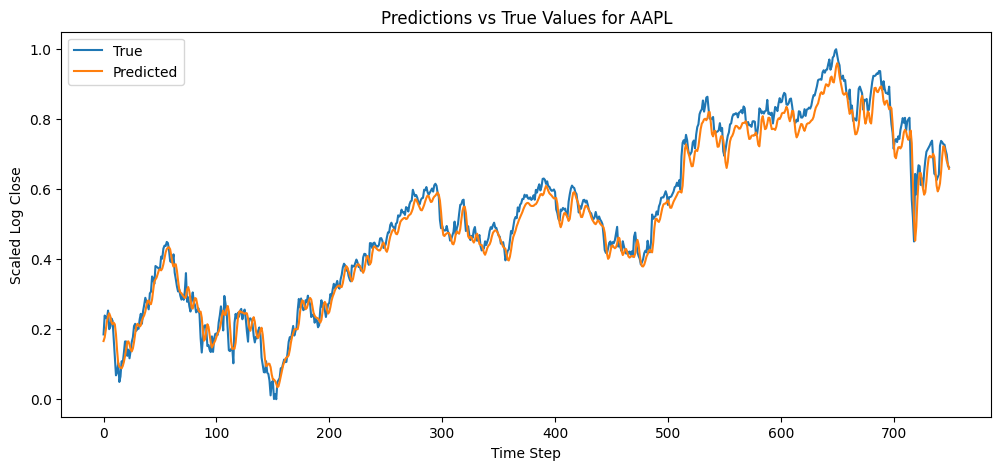

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


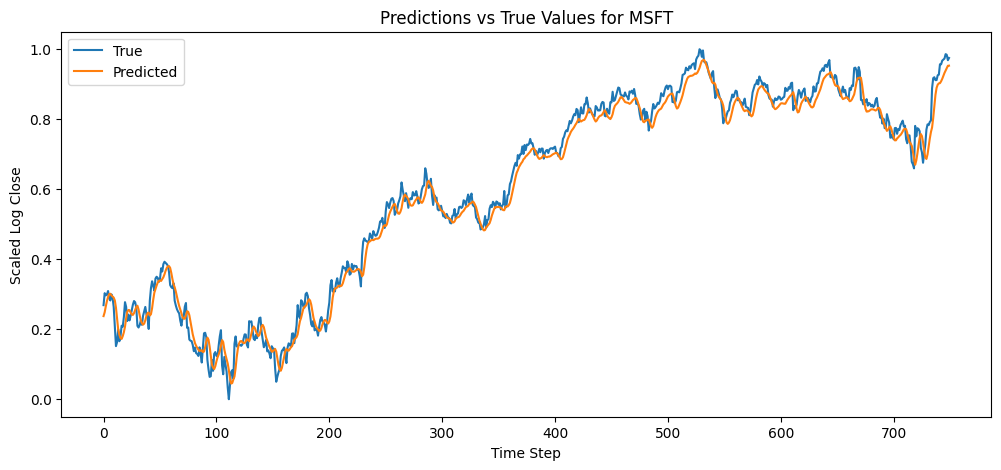

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


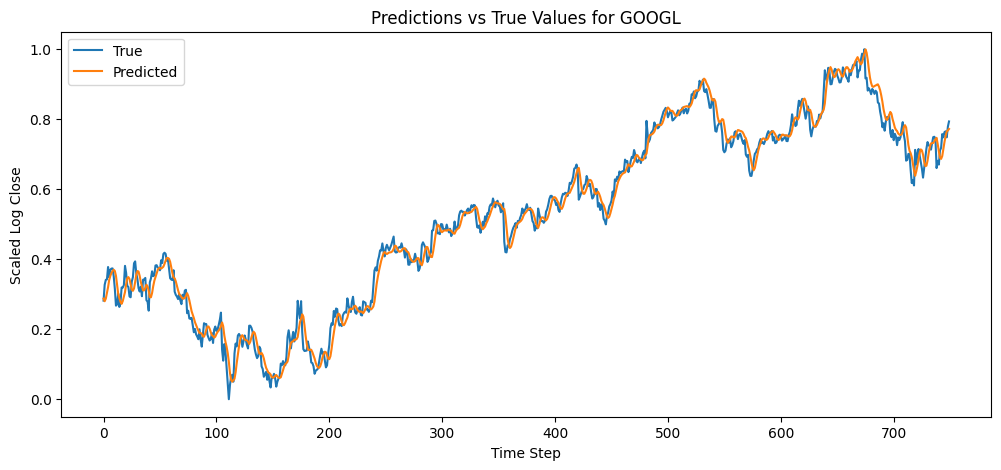

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


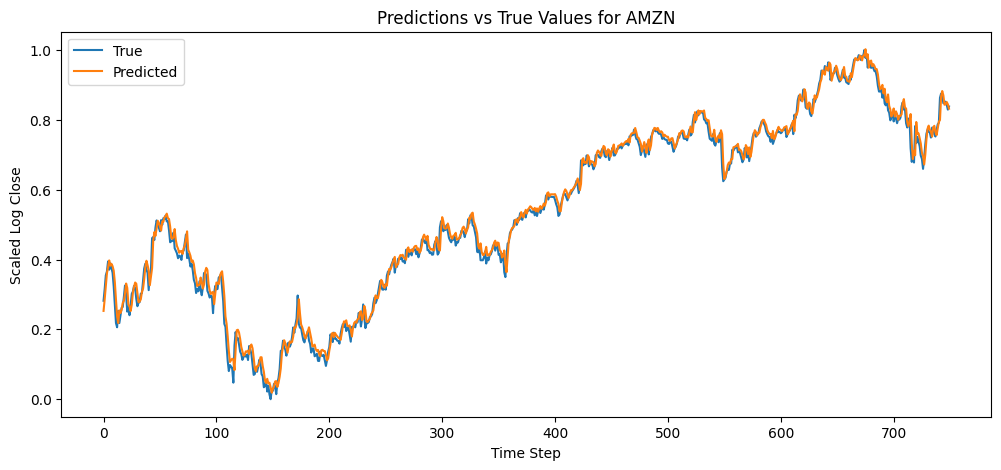

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


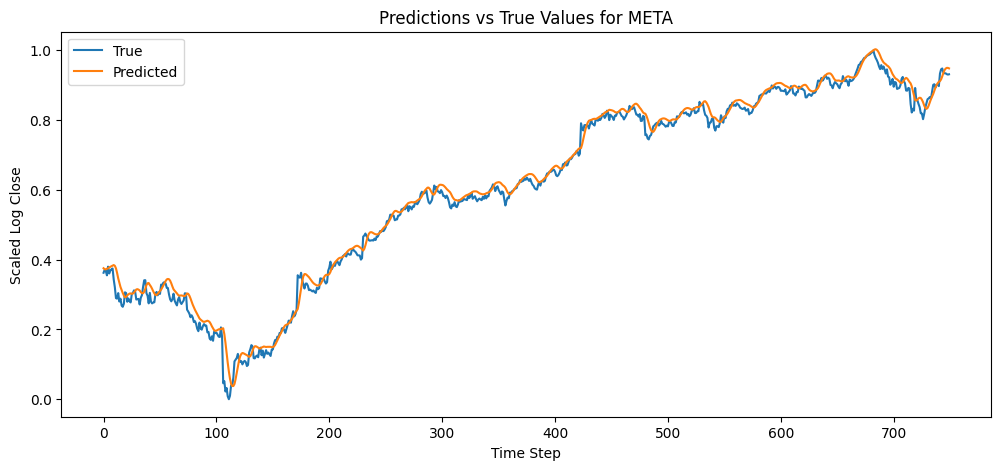

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


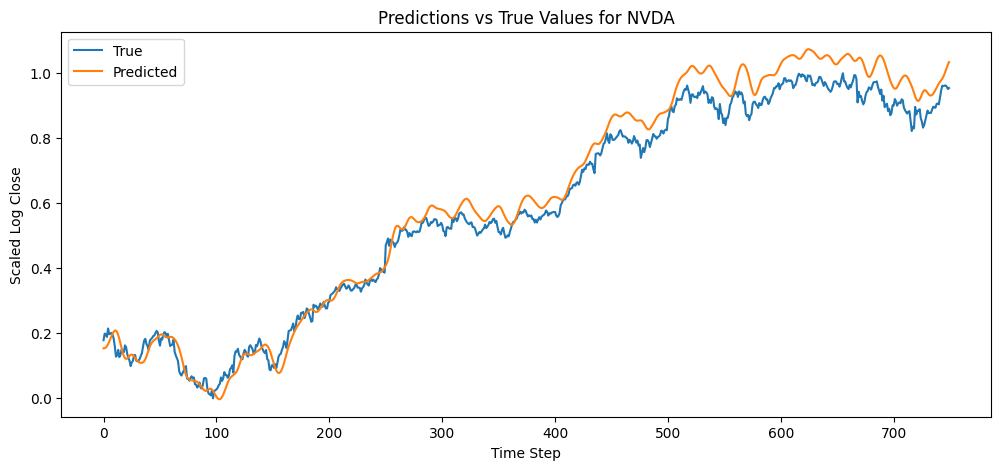

In [ ]:
for symbol in results:
    model = results[symbol]['best_model']
    lookback = results[symbol]['lookback']

    # Get the series for this symbol
    series = stock_data_scaled[stock_data_scaled['Symbol'] == symbol]['Scaled_Log_Close'].values
    X, y = create_sequences(series, lookback)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Predict
    preds = model.predict(X)
    if preds.ndim > 1:
        preds = preds.squeeze()

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y, label='True')
    plt.plot(preds, label='Predicted')
    plt.title(f'Predictions vs True Values for {symbol}')
    plt.xlabel('Time Step')
    plt.ylabel('Scaled Log Close')
    plt.legend()
    plt.show()

###Back testing

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


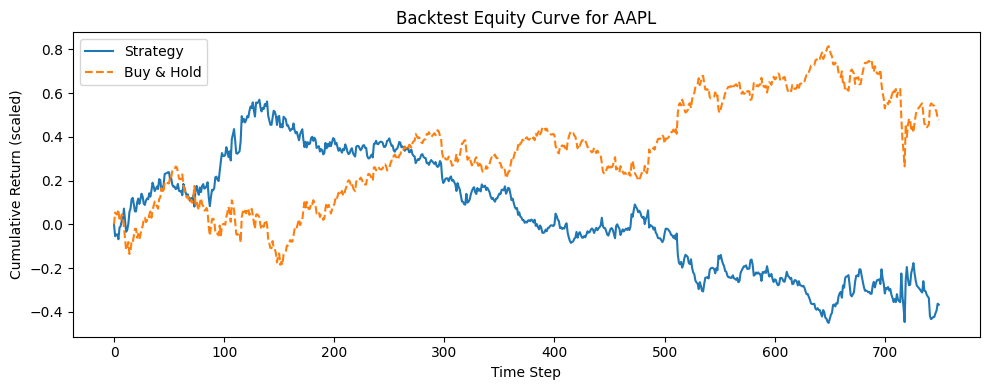

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


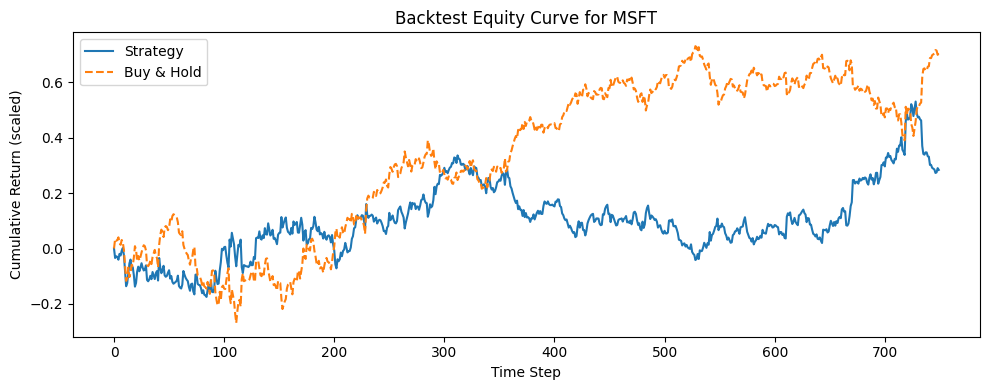

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


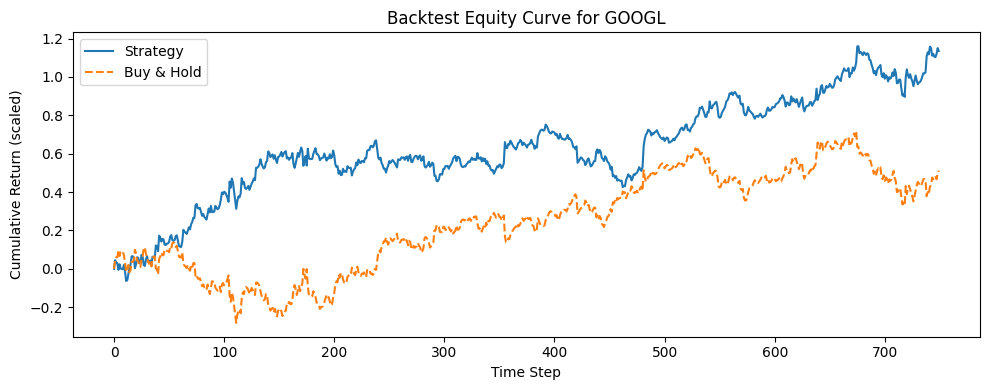

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


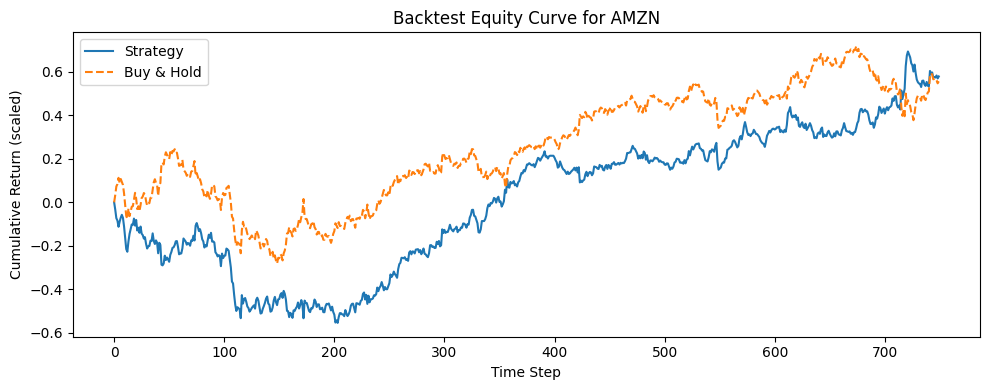

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


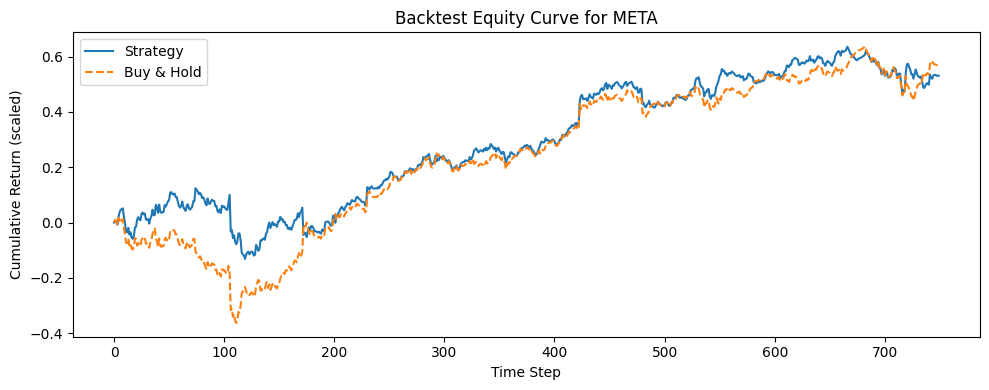

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


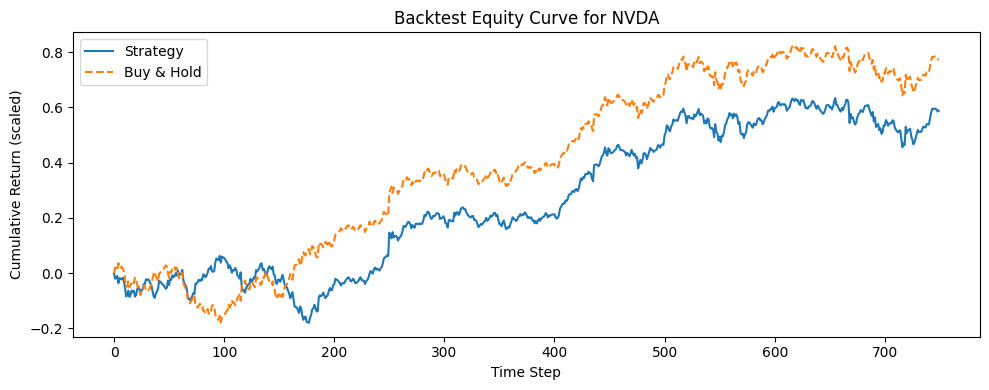

In [ ]:
backtest_results = []

for symbol in results:
    # 1. Get the trained model and lookback for this symbol
    model = results[symbol]['best_model']
    lookback = results[symbol]['lookback']

    # 2. Prepare the data
    series = stock_data_scaled[stock_data_scaled['Symbol'] == symbol]['Scaled_Log_Close'].values
    X, y = create_sequences(series, lookback)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    price = series[lookback:]  # "True" (scaled) price

    # 3. Predict
    y_pred = model.predict(X).squeeze()  # shape (N,)

    # 4. Generate trading signals: 1=long, -1=short
    signal = np.where(y_pred > price, 1, -1)

    # 5. Calculate (scaled) returns for each step
    returns = np.diff(price, prepend=price[0])  # price difference (scaled)

    # 6. Strategy returns: act on yesterday's signal
    strategy_returns = returns * np.roll(signal, 1)
    strategy_returns[0] = 0  # no position first day

    # 7. Cumulative returns
    cum_returns = np.cumsum(strategy_returns)
    bh_cum_returns = np.cumsum(returns)  # buy & hold as reference

    # 8. Metrics
    total_return = cum_returns[-1]
    max_drawdown = np.max(np.maximum.accumulate(cum_returns) - cum_returns)
    sharpe_ratio = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-8) * np.sqrt(252)

    backtest_results.append({
        'symbol': symbol,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    })

        # 9. Plot the equity curve
    plt.figure(figsize=(10,4))
    plt.plot(cum_returns, label='Strategy')
    plt.plot(bh_cum_returns, label='Buy & Hold', linestyle='--')
    plt.title(f'Backtest Equity Curve for {symbol}')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Return (scaled)')
    plt.legend()
    plt.tight_layout()
    plt.show()

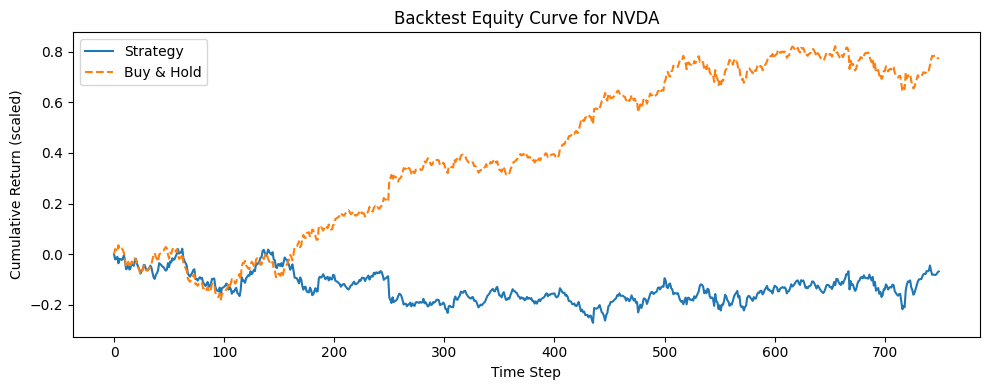

### Prediction

In [ ]:
future_predictions = {}

for symbol in results:
    model = results[symbol]['best_model']
    lookback = results[symbol]['lookback']
    scaler = scalers_dict[symbol]

    # Get the most recent data for this symbol
    df_symbol = stock_data_scaled[stock_data_scaled['Symbol'] == symbol]
    series = df_symbol['Scaled_Log_Close'].values

    # Start from the last lookback window
    window = series[-lookback:].copy()

    pred_scaled_list = []
    pred_log_list = []
    pred_price_list = []

    for step in range(5):
        X_pred = window.reshape((1, lookback, 1))
        pred_scaled = model.predict(X_pred, verbose=0)[0, 0]
        pred_scaled_list.append(pred_scaled)

        # Inverse scale (get log(price))
        log_pred = scaler.inverse_transform([[pred_scaled]])[0, 0]
        pred_log_list.append(log_pred)

        # Exponentiate to get price
        price_pred = np.exp(log_pred)
        pred_price_list.append(price_pred)

        # Update window for next prediction
        window = np.append(window[1:], pred_scaled)

    future_predictions[symbol] = {
        'predicted_scaled': pred_scaled_list,
        'predicted_log': pred_log_list,
        'predicted_price': pred_price_list
    }

    print(f"\n{symbol} next 5 days predicted prices:")
    for i, price in enumerate(pred_price_list, 1):
        print(f"Day {i}: {price:.2f}")


AAPL next 5 days predicted prices:
Day 1: 198.04
Day 2: 195.48
Day 3: 193.34
Day 4: 191.49
Day 5: 189.74

MSFT next 5 days predicted prices:
Day 1: 446.56
Day 2: 444.21
Day 3: 440.91
Day 4: 437.26
Day 5: 433.58

GOOGL next 5 days predicted prices:
Day 1: 168.81
Day 2: 169.62
Day 3: 170.11
Day 4: 170.46
Day 5: 170.75

AMZN next 5 days predicted prices:
Day 1: 203.90
Day 2: 205.34
Day 3: 206.84
Day 4: 208.26
Day 5: 209.53

META next 5 days predicted prices:
Day 1: 657.39
Day 2: 657.76
Day 3: 660.37
Day 4: 664.31
Day 5: 668.98

NVDA next 5 days predicted prices:
Day 1: 165.56
Day 2: 167.73
Day 3: 170.79
Day 4: 175.35
Day 5: 181.60


### Evaluation Regression Metrics

In [ ]:
for symbol in results:
    model = results[symbol]['best_model']
    lookback = results[symbol]['lookback']
    df_symbol = stock_data_scaled[stock_data_scaled['Symbol'] == symbol]
    series = df_symbol['Scaled_Log_Close'].values
    X, y = create_sequences(series, lookback)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Recommend using only validation set for fair evaluation
    split = int(len(X) * 0.7)
    X_val, y_val = X[split:], y[split:]
    y_pred = model.predict(X_val).squeeze()

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"\nEvaluation for {symbol}:")
    print(f"  MSE:   {mse:.6f}")
    print(f"  RMSE:  {rmse:.6f}")
    print(f"  MAE:   {mae:.6f}")
    print(f"  R2:    {r2:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for AAPL:
  MSE:   0.002442
  RMSE:  0.049420
  MAE:   0.041799
  R2:    0.6883
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for MSFT:
  MSE:   0.001162
  RMSE:  0.034083
  MAE:   0.027153
  R2:    0.7531
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for GOOGL:
  MSE:   0.001141
  RMSE:  0.033775
  MAE:   0.025727
  R2:    0.8501
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Evaluation for AMZN:
  MSE:   0.000473
  RMSE:  0.021744
  MAE:   0.015676
  R2:    0.9411
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Evaluation for META:
  MSE:   0.000391
  RMSE:  0.019784
  MAE:   0.015469
  R2:    0.8417
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for NVDA:
  MSE:   0.006381
  RMSE:  0.079880
  MAE:   0.074659
  R2:    -2.7206


In [ ]:

metrics_list = []

for symbol in results:
    model = results[symbol]['best_model']
    lookback = results[symbol]['lookback']
    epochs = results[symbol]['epochs']
    best_hp = results[symbol].get('best_hp', {})
    df_symbol = stock_data_scaled[stock_data_scaled['Symbol'] == symbol]
    series = df_symbol['Scaled_Log_Close'].values
    X, y = create_sequences(series, lookback)
    if X.size == 0:
        print(f"Not enough data for {symbol} with lookback={lookback}, skipping.")
        continue
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Validation split (last 30%)
    split = int(len(X) * 0.7)
    X_val, y_val = X[split:], y[split:]
    y_pred = model.predict(X_val).squeeze()

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"\nEvaluation for {symbol}:")
    print(f"  MSE:   {mse:.6f}")
    print(f"  RMSE:  {rmse:.6f}")
    print(f"  MAE:   {mae:.6f}")
    print(f"  R2:    {r2:.4f}")

    # Flatten best_hp if it's a dict, otherwise just store it as is
    if isinstance(best_hp, dict):
        best_hp_flat = best_hp
    else:
        try:
            best_hp_flat = dict(best_hp)
        except:
            best_hp_flat = {}

    # Save metrics and hyperparameters
    metrics_list.append({
        "symbol": symbol,
        "lookback": lookback,
        "epochs": epochs,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        **best_hp_flat  # Add all best hyperparameters as columns
    })

# Create and print summary DataFrame
df_metrics = pd.DataFrame(metrics_list)
print("\nSummary DataFrame:")
print(df_metrics)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for AAPL:
  MSE:   0.002442
  RMSE:  0.049420
  MAE:   0.041799
  R2:    0.6883
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for MSFT:
  MSE:   0.001162
  RMSE:  0.034083
  MAE:   0.027153
  R2:    0.7531
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for GOOGL:
  MSE:   0.001141
  RMSE:  0.033775
  MAE:   0.025727
  R2:    0.8501
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Evaluation for AMZN:
  MSE:   0.000473
  RMSE:  0.021744
  MAE:   0.015676
  R2:    0.9411
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Evaluation for META:
  MSE:   0.000391
  RMSE:  0.019784
  MAE:   0.015469
  R2:    0.8417
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Evaluation for NVDA:
  MSE:   0.006381
  RMSE:  0.079880
  MAE:   0.074659
  R2:    -2.7206

Summary DataFrame:
  symbol  lookback  epochs       mse      rmse       mae        r2  \
0   AAPL       100      15  0.002442  0.049420  0.041799  0.688333   
1   MSFT       100      15  0.001162  0.034083  0.027153  

In [ ]:
df_metrics.to_csv("metrics_summary.csv", index=False)

### Save the model

In [ ]:
save_dir = "saved_models_v2"
os.makedirs(save_dir, exist_ok=True)

for symbol in results:
    # 1. Save the Keras model
    model = results[symbol]['best_model']
    model_path = os.path.join(save_dir, f"{symbol}_lstm_model.keras")  # New .keras format
    model.save(model_path)

    # 2. Save the scaler
    scaler = scalers_dict[symbol]
    scaler_path = os.path.join(save_dir, f"{symbol}_scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)

    # 3. Save the best hyperparameters and config
    params = {
        "best_hp": results[symbol]['best_hp'],
        "lookback": results[symbol]['lookback'],
        "epochs": results[symbol]['epochs']
    }
    params_path = os.path.join(save_dir, f"{symbol}_params.pkl")
    with open(params_path, "wb") as f:
        pickle.dump(params, f)

    print(f"Saved {symbol} model, scaler, and params.")

print("\nAll models, scalers, and parameters saved to 'saved_models' folder.")

Saved AAPL model, scaler, and params.
Saved MSFT model, scaler, and params.
Saved GOOGL model, scaler, and params.
Saved AMZN model, scaler, and params.
Saved META model, scaler, and params.
Saved NVDA model, scaler, and params.

All models, scalers, and parameters saved to 'saved_models' folder.


### Load the Model

In [ ]:
save_dir = "saved_models_v2"

symbols = [...]  # List of your symbol names, or get from directory
loaded_results = []

for filename in os.listdir(save_dir):
    if filename.endswith("_params.pkl"):
        symbol = filename.split("_params.pkl")[0]

        # Load params
        with open(os.path.join(save_dir, filename), "rb") as f:
            params = pickle.load(f)

        # Load model
        model_path = os.path.join(save_dir, f"{symbol}_lstm_model.keras")
        model = keras.models.load_model(model_path)

        # Load scaler
        scaler_path = os.path.join(save_dir, f"{symbol}_scaler.pkl")
        with open(scaler_path, "rb") as f:
            scaler = pickle.load(f)

        # Collect all into dict
        loaded_results.append({
            "symbol": symbol,
            "model": model,
            "scaler": scaler,
            **params  # Unpack best_hp, lookback, epochs
        })

In [ ]:
from gspread_dataframe import set_with_dataframe

In [ ]:
import gspread

print("gspread imported successfully!")
print("gspread version:", gspread.__version__)

gspread imported successfully!
gspread version: 6.2.1


In [ ]:
!ls /content/drive/MyDrive/Colab_Keys/

ls: cannot access '/content/drive/MyDrive/Colab_Keys/': No such file or directory


In [ ]:
gc = gspread.service_account(filename='/content/drive/MyDrive/Colab_Keys/us-stock-model-9029221637f6.json')

# Open or create the Google Sheet
sh = gc.open('US Stock Models')  # 'My Metrics Sheet' is your Google Sheet name; create one in advance

# Select the first worksheet (or create one)
worksheet = sh.worksheet('Sheet2')

# Write DataFrame to worksheet
set_with_dataframe(worksheet, df_metrics)